# Ocular Disease Recognition

### Author: Jakub Szpunar

In [1]:
import tensorflow as tf

for gpu in tf.config.list_physical_devices("GPU"):
    tf.config.experimental.set_memory_growth(gpu, True)

In [2]:
# imports
import numpy as np
import tensorflow as tf
import keras
import os, shutil

print ("TensorFlow version: " + tf.__version__)
print ("Keras version: " + keras.__version__)

from keras import models
from keras import layers

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

TensorFlow version: 2.10.0
Keras version: 2.10.0


In [3]:
# lists to store models results 
models_acc = []
models_val_acc = []
models_loss = []
models_val_loss = [] 

## 1. Load and explore the [dataset](https://www.kaggle.com/datasets/andrewmvd/ocular-disease-recognition-odir5k) 

### Data analysis

In [4]:
df = pd.read_csv('./data/full_df.csv')
df

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6387,4686,63,Male,4686_left.jpg,4686_right.jpg,severe nonproliferative retinopathy,proliferative diabetic retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4686_left.jpg
6388,4688,42,Male,4688_left.jpg,4688_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4688_left.jpg
6389,4689,54,Male,4689_left.jpg,4689_right.jpg,mild nonproliferative retinopathy,normal fundus,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4689_left.jpg
6390,4690,57,Male,4690_left.jpg,4690_right.jpg,mild nonproliferative retinopathy,mild nonproliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4690_left.jpg


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6392 entries, 0 to 6391
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   ID                         6392 non-null   int64 
 1   Patient Age                6392 non-null   int64 
 2   Patient Sex                6392 non-null   object
 3   Left-Fundus                6392 non-null   object
 4   Right-Fundus               6392 non-null   object
 5   Left-Diagnostic Keywords   6392 non-null   object
 6   Right-Diagnostic Keywords  6392 non-null   object
 7   N                          6392 non-null   int64 
 8   D                          6392 non-null   int64 
 9   G                          6392 non-null   int64 
 10  C                          6392 non-null   int64 
 11  A                          6392 non-null   int64 
 12  H                          6392 non-null   int64 
 13  M                          6392 non-null   int64 
 14  O       

In [7]:
df['target'].value_counts()

[1, 0, 0, 0, 0, 0, 0, 0]    2873
[0, 1, 0, 0, 0, 0, 0, 0]    1608
[0, 0, 0, 0, 0, 0, 0, 1]     708
[0, 0, 0, 1, 0, 0, 0, 0]     293
[0, 0, 1, 0, 0, 0, 0, 0]     284
[0, 0, 0, 0, 1, 0, 0, 0]     266
[0, 0, 0, 0, 0, 0, 1, 0]     232
[0, 0, 0, 0, 0, 1, 0, 0]     128
Name: target, dtype: int64

### Divide each class images into the separate directory

In [8]:
# Class labels
df.labels.unique()

array(["['N']", "['D']", "['O']", "['M']", "['H']", "['C']", "['A']",
       "['G']"], dtype=object)

Annotations were labeled by trained human readers with quality control management. They classify patient into eight labels including:
* Normal (N)
* Diabetes (D)
* Glaucoma (G)
* Cataract (C)
* Age related Macular Degeneration (A)
* Hypertension (H)
* Pathological Myopia (M)
* Other diseases/abnormalities (O)

In [9]:
# The path to store trained models
models_dir = r'./models/' 
if not os.path.exists(models_dir):
    os.mkdir(models_dir)

# The path to the directory where is original dataset
original_dataset_dir = r'./data/preprocessed_images/'

# The directory where we will store our smaller dataset
base_dir = r'./dataset/'
if not os.path.exists(base_dir):
    os.mkdir(base_dir)

split_dir = base_dir + r'split/'
if not os.path.exists(split_dir):
    os.mkdir(split_dir)

# Prepare directories for the class separation
normal_dir = os.path.join(split_dir, r'normal')
if not os.path.exists(normal_dir):
    os.mkdir(normal_dir)
    
diabetes_dir = os.path.join(split_dir, r'diabetes')
if not os.path.exists(diabetes_dir):
    os.mkdir(diabetes_dir)
    
glaucoma_dir = os.path.join(split_dir, r'glaucoma')
if not os.path.exists(glaucoma_dir):
    os.mkdir(glaucoma_dir)
    
cataract_dir = os.path.join(split_dir, r'cataract')
if not os.path.exists(cataract_dir):
    os.mkdir(cataract_dir)
    
age_macular_dir = os.path.join(split_dir, r'age_macular')
if not os.path.exists(age_macular_dir):
    os.mkdir(age_macular_dir)
    
hypertension_dir = os.path.join(split_dir, r'hypertension')
if not os.path.exists(hypertension_dir):
    os.mkdir(hypertension_dir)
    
myopia_dir = os.path.join(split_dir, r'myopia')
if not os.path.exists(myopia_dir):
    os.mkdir(myopia_dir)

other_dir = os.path.join(split_dir, r'other')
if not os.path.exists(other_dir):
    os.mkdir(other_dir)

### Copy images into the directories associated with appropriate class

In [10]:
# get images' filenames classified as normal, analogically other classes
df[df.labels == "['N']"].head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
7,8,59,Male,8_left.jpg,8_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",8_right.jpg
9,10,70,Male,10_left.jpg,10_right.jpg,epiretinal membrane,normal fundus,0,0,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",10_right.jpg
24,29,59,Male,29_left.jpg,29_right.jpg,epiretinal membrane,normal fundus,0,0,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",29_right.jpg


In [11]:
df[df.labels == "['N']"].filename

0         0_right.jpg
1         1_right.jpg
7         8_right.jpg
9        10_right.jpg
24       29_right.jpg
            ...      
6356    4637_left.jpg
6358    4639_left.jpg
6360    4641_left.jpg
6378    4672_left.jpg
6386    4683_left.jpg
Name: filename, Length: 2873, dtype: object

In [12]:
df[df.target == "[0, 0, 0, 0, 0, 0, 0, 1]"]

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
8,9,54,Male,9_left.jpg,9_right.jpg,normal fundus,vitreous degeneration,0,0,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['O'],"[0, 0, 0, 0, 0, 0, 0, 1]",9_right.jpg
12,14,55,Male,14_left.jpg,14_right.jpg,normal fundus,macular epiretinal membrane,0,0,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['O'],"[0, 0, 0, 0, 0, 0, 0, 1]",14_right.jpg
13,15,50,Male,15_left.jpg,15_right.jpg,normal fundus,myelinated nerve fibers,0,0,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['O'],"[0, 0, 0, 0, 0, 0, 0, 1]",15_right.jpg
15,17,57,Male,17_left.jpg,17_right.jpg,drusen,drusen,0,0,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['O'],"[0, 0, 0, 0, 0, 0, 0, 1]",17_right.jpg
18,21,76,Female,21_left.jpg,21_right.jpg,epiretinal membrane,epiretinal membrane,0,0,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['O'],"[0, 0, 0, 0, 0, 0, 0, 1]",21_right.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4542,1999,60,Male,1999_left.jpg,1999_right.jpg,epiretinal membrane，lens dust,epiretinal membrane，lens dust，glaucoma,0,0,1,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['O'],"[0, 0, 0, 0, 0, 0, 0, 1]",1999_left.jpg
4544,2006,44,Male,2006_left.jpg,2006_right.jpg,maculopathy，glaucoma,maculopathy,0,0,1,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['O'],"[0, 0, 0, 0, 0, 0, 0, 1]",2006_left.jpg
4546,2020,51,Male,2020_left.jpg,2020_right.jpg,myelinated nerve fibers，suspected glaucoma,normal fundus,0,0,1,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['O'],"[0, 0, 0, 0, 0, 0, 0, 1]",2020_left.jpg
4583,2118,77,Female,2118_left.jpg,2118_right.jpg,refractive media opacity,cataract,0,0,0,1,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['O'],"[0, 0, 0, 0, 0, 0, 0, 1]",2118_left.jpg


### For convenience create class to keep information about each data class

In [13]:
class DataClass():
    def __init__(self, _name: str, _filenames: [str], _target: [int], _abbreviation: str, _directory: str):
        self.name = _name
        self.filenames = _filenames
        self.target = _target
        self.abbreviation  = _abbreviation
        self.directory = _directory
        
    def __str__(self):
        return f"name: {self.name}\n" \
        f"filenames[:5]:\n {self.filenames[:5]}\n" \
        f"target: {self.target[:8]}\n"\
        f"abbrevation: {self.abbreviation}\n" \
        f"directory: {self.directory}"
    
    def __repr__(self):
        return f"name: {self.name}\n" \
        f"filenames[:5]:\n {self.filenames[:5]}\n" \
        f"target: {self.target[:8]}\n"\
        f"abbrevation: {self.abbreviation}\n" \
        f"directory: {self.directory}"

normal_filenames = df[df.labels == "['N']"].filename.values
diabetes_filenames = df[df.labels == "['D']"].filename.values
glaucoma_filenames = df[df.labels == "['G']"].filename.values
cataract_filenames = df[df.labels == "['C']"].filename.values
age_macular_filenames = df[df.labels == "['A']"].filename.values
hypertension_filenames = df[df.labels == "['H']"].filename.values
myopia_filenames = df[df.labels == "['M']"].filename.values
other_filenames = df[df.labels == "['O']"].filename.values

normal_class = DataClass('normal', normal_filenames, [1, 0, 0, 0, 0, 0, 0, 0], 'N', normal_dir)
diabetes_class = DataClass('diabetes', diabetes_filenames, [0, 1, 0, 0, 0, 0, 0, 0], 'D', diabetes_dir)
glaucoma_class = DataClass('glaucoma', glaucoma_filenames, [0, 0, 1, 0, 0, 0, 0, 0], 'G', glaucoma_dir)
cataract_class = DataClass('cataract', cataract_filenames, [0, 0, 0, 1, 0, 0, 0, 0], 'C', cataract_dir)
age_macular_class = DataClass('age_macular', age_macular_filenames, [0, 0, 0, 0, 1, 0, 0, 0], 'A', age_macular_dir)
hypertension_class = DataClass('hypertension', hypertension_filenames, [0, 0, 0, 0, 0, 1, 0, 0], 'H', hypertension_dir)
myopia_class = DataClass('myopia', myopia_filenames, [0, 0, 0, 0, 0, 0, 1, 0], 'M', myopia_dir)
other_class = DataClass('other', other_filenames, [0, 0, 0, 0, 0, 0, 0, 1], 'O', other_dir)

data_classes = [
    normal_class, 
    diabetes_class, 
    glaucoma_class, 
    cataract_class, 
    age_macular_class, 
    hypertension_class, 
    myopia_class, 
    other_class
]

In [14]:
# Copy files to each class dir
for data_class in data_classes:
    class_dir = data_class.directory
    if os.path.exists(class_dir) and not os.path.isfile(class_dir):
        # Check if the directory is empty
        if not os.listdir(class_dir):
            # copy files
            for fname in data_class.filenames:
                src = os.path.join(original_dataset_dir, fname)
                dst = data_class.directory + "/" + fname
                shutil.copyfile(src, dst)
    # validate if number of each class in dataframe and destination directory is the same
    assert(len(df[df.labels == "['" + data_class.abbreviation +  "']"]) == len(os.listdir(class_dir)))

### Quick look at the data

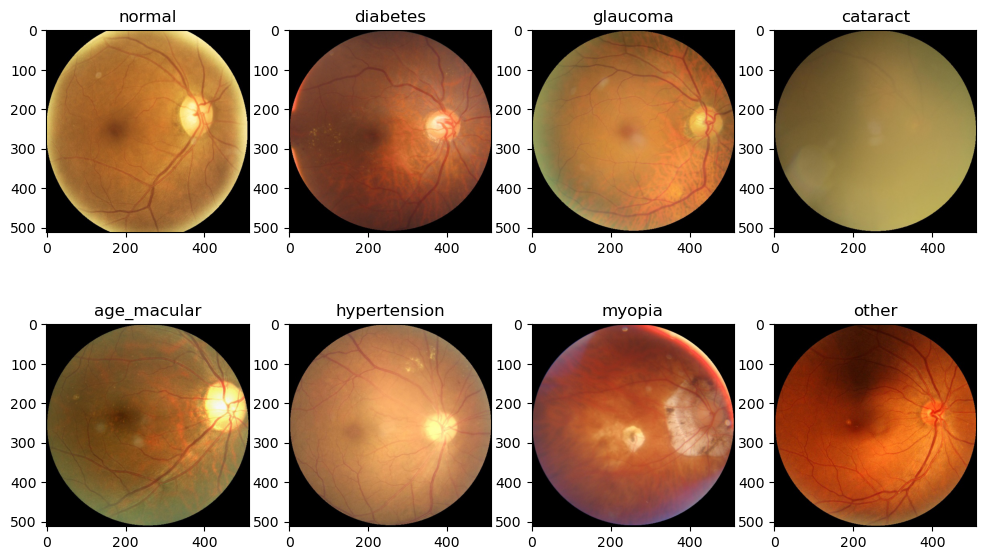

In [15]:
fig, axs = plt.subplots(2,4, figsize=(12,7))
for i, data_class in enumerate(data_classes):
    image = plt.imread(f"{data_class.directory}/{data_class.filenames[64]}")
    axs[0 if i < 4 else 1, i % 4].imshow(image)
    axs[0 if i < 4 else 1, i % 4].set_title(data_class.name)

### Unfortunately, data distribution for each class is uneven.

In [16]:
classes = []
num_of_imgs = []

for data_class in data_classes:
    classes.append(data_class.name)
    num_of_imgs.append(len(data_class.filenames))

print(classes)
print(num_of_imgs)

['normal', 'diabetes', 'glaucoma', 'cataract', 'age_macular', 'hypertension', 'myopia', 'other']
[2873, 1608, 284, 293, 266, 128, 232, 708]


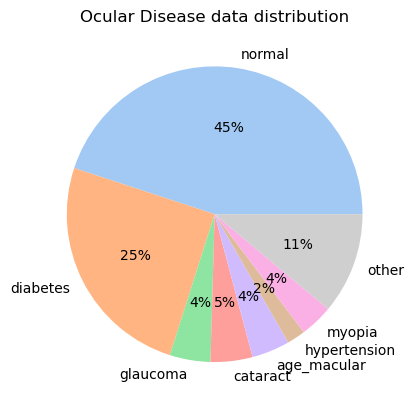

In [17]:
colors = sns.color_palette('pastel')[0:len(classes)]

plt.pie(num_of_imgs, labels = classes, colors = colors, autopct='%.0f%%')
plt.title('Ocular Disease data distribution')
plt.show()

#### Accuracy isn't the right choice when it comes to metrics since this dataset is filled mainly with `normal` class images. Model recognising only this particular class might have accuracy ~50% even though other classes might be labeled incorrectly. <br><br> Confusion matrix will undoubtedly be helpful in this case to find how model copes with our problem.

### There are 6392 images in the dataset. 
Split the data:
* Train - 70%: `~4474 images`
* Validation - 15%: `~958 images`
* Test - 15%: `~958 images`

In [18]:
from sklearn.model_selection import train_test_split

# prepare data sets
def prepare_data(data_class: DataClass, train_size: float):
    # check if directories are created
    class_train_dir = os.path.join(train_dir, data_class.name)
    if not os.path.exists(class_train_dir):
        os.mkdir(class_train_dir)

    class_validation_dir = os.path.join(validation_dir, data_class.name)
    if not os.path.exists(class_validation_dir):
        os.mkdir(class_validation_dir)

    class_test_dir = os.path.join(test_dir, data_class.name)
    if not os.path.exists(class_test_dir):
        os.mkdir(class_test_dir)
    
    # split class filenames into three separate bins in line with split ratio
    train_filenames, test_valid_filenames = train_test_split(data_class.filenames, test_size=1.0-train_size)
    # divide images into test and validation sets equally
    validation_filenames, test_filenames = train_test_split(test_valid_filenames, test_size=0.5)
    
    for key, destination_dir, filenames in [('train', class_train_dir, train_filenames), ('test', class_test_dir, test_filenames), ('validation', class_validation_dir, validation_filenames)]:
        if os.path.exists(destination_dir) and not os.path.isfile(destination_dir):
            # Checking if the directory is empty or not
            if not os.listdir(destination_dir):
                # copy files
                for filename in filenames:
                    src = os.path.join(split_dir + f"/{data_class.name}", filename)
                    dst = os.path.join(destination_dir, filename)
                    shutil.copyfile(src, dst)
        # validate if number of each class in dataframe and destination directory is the same
        assert(len(filenames) == len(os.listdir(destination_dir)))

# [2. Initial data preprocessing](https://keras.io/api/preprocessing/image/)

In [5]:
train_dir = r'./dataset/train/'
validation_dir = r'./dataset/validation/'
test_dir = r'./dataset/test/'

img_rows = 512
img_cols = 512
num_class = 8

In [6]:
from keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    # This is the target directory
    train_dir,
    # All images will be resized to 150x150
    target_size=(img_rows, img_cols),
    # The size of baches of images
    batch_size=5,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    # This is the target directory
    test_dir,
    # All images will be resized to 150x150
    target_size=(img_rows, img_cols),
    # The size of baches of images
    batch_size=5,
    
    class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
    # This is the target directory
    validation_dir,
    # All images will be resized to 150x150
    target_size=(img_rows, img_cols),
    # The size of baches of images
    batch_size=5,
    class_mode='categorical')

Found 4471 images belonging to 8 classes.
Found 962 images belonging to 8 classes.
Found 959 images belonging to 8 classes.


# 3. Create CNN model

In [7]:
model1 = models.Sequential()
model1.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_rows, img_cols, 3)))
model1.add(layers.MaxPooling2D((2, 2)))
model1.add(layers.Conv2D(64, (3, 3), activation='relu'))
model1.add(layers.MaxPooling2D((2, 2)))
model1.add(layers.Conv2D(128, (3, 3), activation='relu'))
model1.add(layers.MaxPooling2D((2, 2)))
model1.add(layers.Flatten())
model1.add(layers.Dense(64, activation='relu'))
model1.add(layers.Dense(num_class, activation='softmax'))

In [22]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 510, 510, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 255, 255, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 253, 253, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 126, 126, 64)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 124, 124, 128)     73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 62, 62, 128)      0

In [23]:
model1.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
              metrics=['acc'])

In [24]:
history1 = model1.fit(
      train_generator,
      steps_per_epoch=89,
      epochs=50,
      validation_data=validation_generator,
      validation_steps=19)

Epoch 1/50
89/89 [==============================] - 13s 104ms/step - loss: 1.6814 - acc: 0.4652 - val_loss: 1.4004 - val_acc: 0.5684
Epoch 2/50
89/89 [==============================] - 9s 105ms/step - loss: 1.6198 - acc: 0.4558 - val_loss: 1.6591 - val_acc: 0.4105
Epoch 3/50
89/89 [==============================] - 9s 101ms/step - loss: 1.5798 - acc: 0.4512 - val_loss: 1.5509 - val_acc: 0.4632
Epoch 4/50
89/89 [==============================] - 9s 101ms/step - loss: 1.5530 - acc: 0.4584 - val_loss: 1.6139 - val_acc: 0.4421
Epoch 5/50
89/89 [==============================] - 9s 101ms/step - loss: 1.5950 - acc: 0.4308 - val_loss: 1.6222 - val_acc: 0.4211
Epoch 6/50
89/89 [==============================] - 9s 103ms/step - loss: 1.6246 - acc: 0.4337 - val_loss: 1.4905 - val_acc: 0.4526
Epoch 7/50
89/89 [==============================] - 9s 100ms/step - loss: 1.5722 - acc: 0.4517 - val_loss: 1.5720 - val_acc: 0.4316
Epoch 8/50
89/89 [==============================] - 9s 100ms/step - loss: 1

In [25]:
result1 = model1.evaluate(test_generator)
dict(zip(model1.metrics_names, result1))

193/193 [==============================] - 8s 40ms/step - loss: 1.4821 - acc: 0.4896


{'loss': 1.4821242094039917, 'acc': 0.48960497975349426}

### Confusion matrix 

In [26]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

test_steps_per_epoch = np.math.ceil(test_generator.samples / test_generator.batch_size)
Y_pred = model1.predict(test_generator, steps=test_steps_per_epoch)
y_pred = np.argmax(Y_pred, axis=1)

193/193 [==============================] - 7s 35ms/step


In [27]:
conf_matrix_result = confusion_matrix(test_generator.classes, y_pred)
clssification_report_result = classification_report(test_generator.classes, y_pred)

print('Confusion Matrix')
print(conf_matrix_result)

print('Classification Report')
print(clssification_report_result)

Confusion Matrix
[[  0   0   5   0   0   0  35   0]
 [  0   0   3   0   0   1  38   2]
 [  0   8  23   0   0   4 200   7]
 [  0   1   2   0   0   0  39   1]
 [  0   2   4   0   0   0  14   0]
 [  0   2   1   0   0   1  31   0]
 [  0  14  44   0   0   5 363   5]
 [  0   2  10   0   0   1  94   0]]
Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        40
           1       0.00      0.00      0.00        44
           2       0.25      0.10      0.14       242
           3       0.00      0.00      0.00        43
           4       0.00      0.00      0.00        20
           5       0.08      0.03      0.04        35
           6       0.45      0.84      0.58       431
           7       0.00      0.00      0.00       107

    accuracy                           0.40       962
   macro avg       0.10      0.12      0.10       962
weighted avg       0.27      0.40      0.30       962



C:\Users\kuba2\anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kuba2\anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kuba2\anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [28]:
# class distribution in test generator
pd.DataFrame(test_generator.classes).value_counts()

6    431
2    242
7    107
1     44
3     43
0     40
5     35
4     20
dtype: int64

In [29]:
conf_matrix_result

array([[  0,   0,   5,   0,   0,   0,  35,   0],
       [  0,   0,   3,   0,   0,   1,  38,   2],
       [  0,   8,  23,   0,   0,   4, 200,   7],
       [  0,   1,   2,   0,   0,   0,  39,   1],
       [  0,   2,   4,   0,   0,   0,  14,   0],
       [  0,   2,   1,   0,   0,   1,  31,   0],
       [  0,  14,  44,   0,   0,   5, 363,   5],
       [  0,   2,  10,   0,   0,   1,  94,   0]], dtype=int64)

In [30]:
# Keras sorts the labels (names of folders in the train directory) by alphabetical order
classes = sorted([data_class.name for data_class in data_classes])
classes

['age_macular',
 'cataract',
 'diabetes',
 'glaucoma',
 'hypertension',
 'myopia',
 'normal',
 'other']

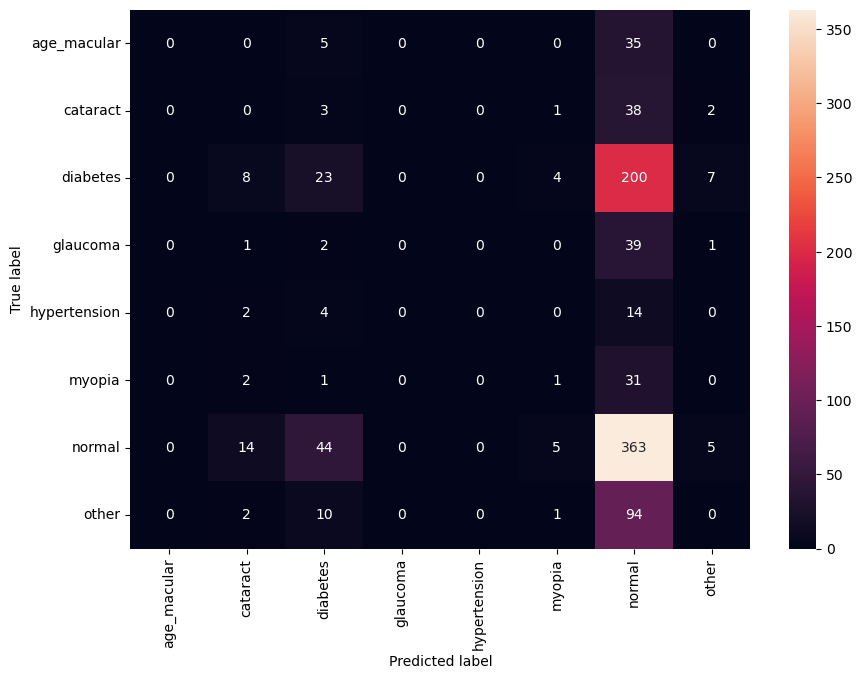

In [31]:
df_cm = pd.DataFrame(conf_matrix_result, index = classes,
                  columns = classes)
plt.figure(figsize = (10,7))
ax = sns.heatmap(df_cm, annot=True, fmt="")
ax.set(xlabel='Predicted label', ylabel='True label');

193/193 [==============================] - 7s 36ms/step


C:\Users\kuba2\anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kuba2\anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\kuba2\anaconda3\envs\ML\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


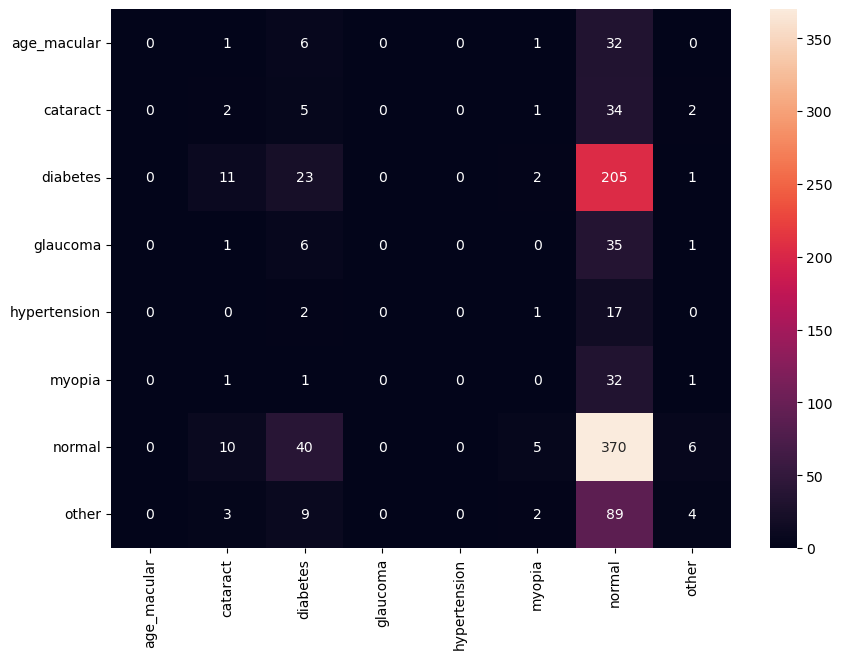

In [32]:
# create method for confusion matrix plotting
def plot_conf_matrix(model, test_generator, classes):
    test_steps_per_epoch = np.math.ceil(test_generator.samples / test_generator.batch_size)
    Y_pred = model1.predict(test_generator, steps=test_steps_per_epoch)
    y_pred = np.argmax(Y_pred, axis=1)
    
    conf_matrix_result = confusion_matrix(test_generator.classes, y_pred)
    clssification_report_result = classification_report(test_generator.classes, y_pred)
    
    # print('Confusion Matrix')
    # print(conf_matrix_result)
    # print('Classification Report')
    # print(clssification_report_result)
    
    # Keras sorts the labels (names of folders in the train directory) by alphabetical order
    alphabetical_classes = sorted(classes)
    
    df_cm = pd.DataFrame(conf_matrix_result, index = alphabetical_classes,
                  columns = alphabetical_classes)
    plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, annot=True, fmt="")

plot_conf_matrix(model1, test_generator, classes)

Almost all images are assigned to the `normal` class because model architecture isn't adjusted properly to the problem. Also using `accuracy` as metric is incorrect approach with the current data distribution. 

In this case metrics such as `recall`, `precision` or  `F1` are better options.

### Accuracy plot

In [33]:
import matplotlib.pyplot as plt  # library for plotting math functions: https://matplotlib.org/stable/index.html
    
def PlotAccuracyComparison(acc, val_acc, lab = '*'):
    plt.clf()   # clear figure
    #plt.rcParams['figure.figsize'] = (25.0, 5.0) # set default size of plots
    plt.figure(figsize=(25,5))
    epochs = range(len(acc))
    plt.plot(epochs, acc, 'bo', label='Training accuracy for ' + lab)
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy for ' + lab)
    plt.title('Comparison of Training and Validation Accuracies')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    
def PlotLossComparison(loss, val_loss, lab = '*'):
    plt.clf()   # clear figure
    #plt.rcParams['figure.figsize'] = (25.0, 5.0) # set default size of plots
    plt.figure(figsize=(25,5))
    epochs = range(len(loss))
    plt.plot(epochs, loss, 'bo', label='Training loss for ' + lab)
    plt.plot(epochs, val_loss, 'b', label='Validation loss for ' + lab)
    plt.title('Comparison of Training and Validation Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

<Figure size 640x480 with 0 Axes>

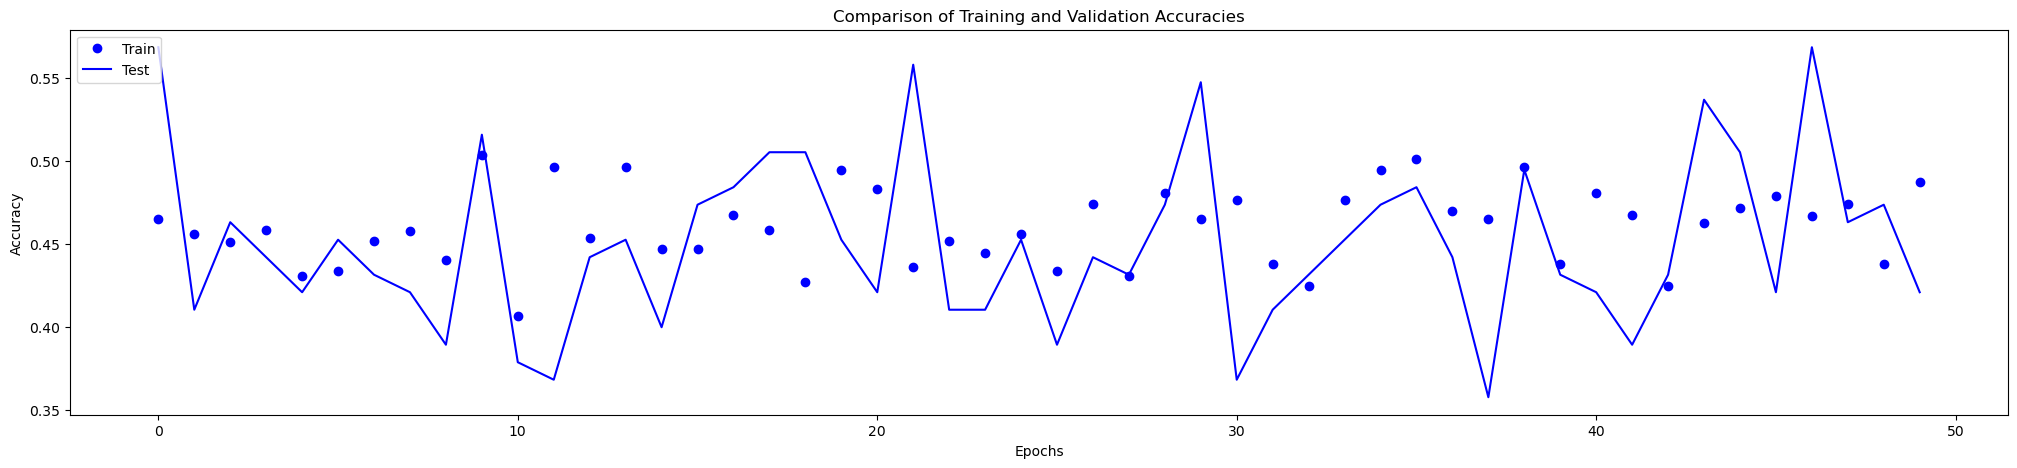

<Figure size 640x480 with 0 Axes>

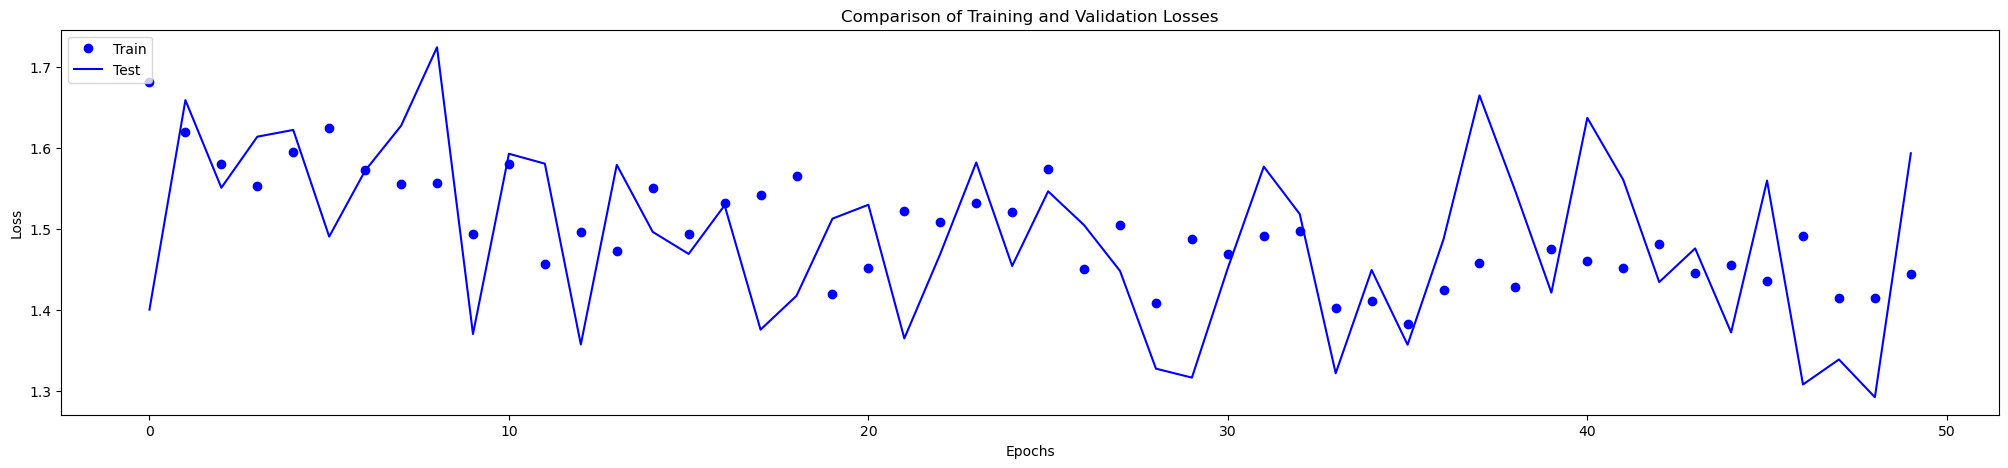

In [34]:
acc1 = history1.history['acc']
val_acc1 = history1.history['val_acc']
loss1 = history1.history['loss']
val_loss1 = history1.history['val_loss']

models_acc.append(acc1)
models_val_acc.append(val_acc1)
models_loss.append(loss1)
models_val_loss.append(val_loss1)

PlotAccuracyComparison(acc1, val_acc1, lab = 'Model 1')
PlotLossComparison(loss1, val_loss1, lab = 'Model 1')